In [21]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers

from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix


In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [3]:
train_img = []
train_labels = []
image_size = 150
for i in labels:
    folderPath = os.path.join('mri-data/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is None:
            pass
        else:
            img = cv2.resize(img,(image_size,image_size))
            train_img.append(img)
            train_labels.append(i)

for i in labels:
    folderPath = os.path.join('mri-data/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is None:
            pass
        else:
            img = cv2.resize(img,(image_size,image_size))
            train_img.append(img)
            train_labels.append(i)


100%|██████████| 74/74 [00:26<00:00,  2.80it/s]


In [4]:
X_train,X_test,y_train,y_test = train_test_split(train_img,train_labels, test_size=0.1,random_state=101)


In [5]:
mapping = {}
for x in range(len(labels)):
    mapping[labels[x]] = x

In [6]:
mapping

{'glioma_tumor': 0, 'no_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}

### one hot encoding

In [7]:
y_train_ohe = []

for i in y_train:
    arr = list(np.zeros(len(labels), dtype = int))
    arr[mapping[i]] = 1
    y_train_ohe.append(arr)

In [8]:
y_test_ohe = []

for i in y_test:
    arr = list(np.zeros(len(labels), dtype = int))
    arr[mapping[i]] = 1
    y_test_ohe.append(arr)

In [25]:
effNetB0 = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))


In [26]:
CNN_model = effNetB0.output
CNN_model = tf.keras.layers.GlobalAveragePooling2D()(CNN_model)
CNN_model = tf.keras.layers.Dropout(rate=0.5)(CNN_model)
CNN_model = tf.keras.layers.Dense(4,activation='softmax')(CNN_model)
CNN_model = tf.keras.models.Model(inputs=effNetB0.input, outputs = CNN_model)

In [27]:
CNN_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1[0][0]'

In [28]:
CNN_model.compile(loss='categorical_crossentropy', metrics= ['accuracy']) #use adam optimizer to improve accuracy, ,optimizer = 'Adam'


In [29]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [30]:
X_train = np.array(X_train)
y_train_ohe = np.array(y_train_ohe)
history = CNN_model.fit(X_train,y_train_ohe,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                        callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.8173
Epoch 1: val_accuracy improved from -inf to 0.82653, saving model to effnet.h5
83/83 [==============================] - 139s 2s/step - loss: 0.4781 - accuracy: 0.8173 - val_loss: 0.6768 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9243
Epoch 2: val_accuracy improved from 0.82653 to 0.91156, saving model to effnet.h5
83/83 [==============================] - 150s 2s/step - loss: 0.2192 - accuracy: 0.9243 - val_loss: 0.4476 - val_accuracy: 0.9116 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9531
Epoch 3: val_accuracy did not improve from 0.91156
83/83 [==============================] - 143s 2s/step - loss: 0.1458 - accuracy: 0.9531 - val_loss: 0.4845 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.1276 - 

In [35]:
CNN_model.save('MRI_CNN.keras')

In [43]:
CNN_model.save("CNN.h5")

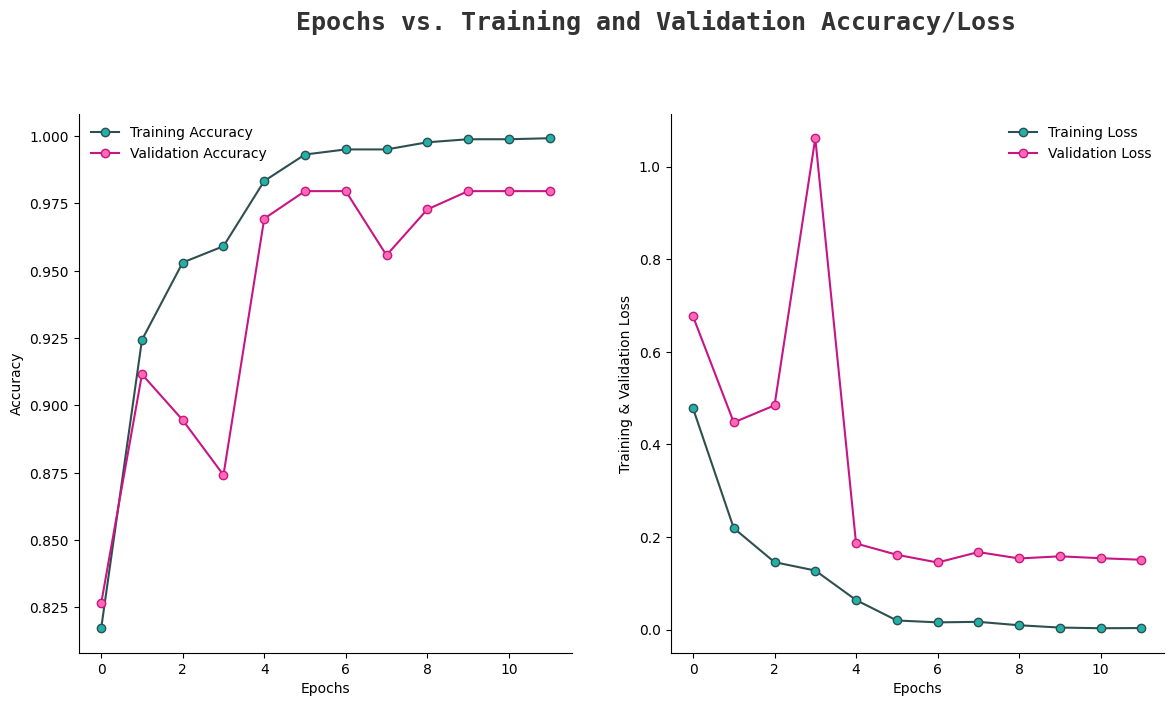

In [32]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color="black",y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor="lightseagreen",color="darkslategrey",
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor="hotpink",color="mediumvioletred",
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor="lightseagreen",color="darkslategrey",
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor="hotpink",color="mediumvioletred",
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()
fig.savefig("AccuracyLoss.png")


In [33]:
pred = CNN_model.predict(X_test, batch_size=32)  # Use an appropriate batch size
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test_ohe,axis=1)

11/11 [==============================] - 4s 284ms/step


In [42]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96        97
           1       0.98      1.00      0.99        48
           2       0.94      0.97      0.96       101
           3       0.98      1.00      0.99        81

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



In [36]:
report = classification_report(y_test_new,pred)
df = pd.DataFrame(report)#.transpose()
df.to_csv('classification_report.csv')

ValueError: DataFrame constructor not properly called!

In [40]:
model_json = CNN_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)